# Částice reprezentované tuhými kruhy ve čtverci

Uvažme $N$ částic ve tvaru kruhů o poloměru $\text{radius}$ a hmotnostech $M=1$ s počátečními souřadnicemi $\text{position}_i$ a počátečními rychlostmi $\text{velocity}_i$ (rychlosti mají Maxwellovo rozdělení), jež jsou uzavřeny v obdélníku se stranami $\text{limit}_x$ a $\text{limit}_y$. Uvažovat budeme srážky dvou částic a srážky částice se stěnou (zanedbáme tedy srážky více částic).

Napřed importujeme knihovny a iniciujeme konstanty:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

limit_x = 500
limit_y = 500

sq_number_of_particles = 100
number_of_particles = sq_number_of_particles**2 # must be a square 400 = 20**2

radius = 1

Počáteční podmínky částic: Polohy jsou na začátku zadány pravidelně.  Budeme dále předpokládat, že částice mají Maxwellovo rozdělení rychlostí. Spočteme také velikosti rychlostí částic (nebudou se měnit) a normované velikosti rychlostí kvůli obarvení.

In [2]:
x=np.linspace(radius,limit_x-radius,sq_number_of_particles,endpoint=True)
y=np.linspace(radius,limit_y-radius,sq_number_of_particles,endpoint=True)
position = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
velocity = np.random.normal(0,0.2,(number_of_particles,2))
vel_norm = np.linalg.norm(velocity,axis=1)
vel_norm_max=np.amax(vel_norm)
normalized_vel_norm = vel_norm/vel_norm_max
size = radius**2

Nyní zobrazíme počáteční polohy.

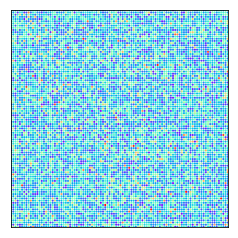

In [ ]:
plt.scatter(*zip(*position),s=size,color=cm.rainbow(normalized_vel_norm))
plt.gca().set_aspect('equal')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.axis([0,limit_x,0,limit_y])
plt.show()
plt.close()

Nyní v jednoduché smyčce dochází k evoluci systému a po pravidelné době k uložení situace ve formě obrázku.

In [ ]:
l = 0
m = 0
while l<15000:
    if l%15 == 0:
        m += 1
        plt.scatter(*zip(*position),s=size,color=cm.jet(normalized_vel_norm))
        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.axis([0,limit_x,0,limit_y])
        plt.savefig("sim{num:04d}".format(num=m),dpi=192,bbox_inches='tight')
        plt.close()

    position += velocity

    # make 3D arrays with repeated position vectors to form combinations
    # diff_i[i][j] = position[i]
    # diff_j[i][j] = position[j]
    # diff[i][j] = vector pointing from i to j
    # norm[i][j] = sqrt( diff[i][j]**2 )
    nop = number_of_particles
    diff_i = np.repeat(position.reshape(1, nop, 2), nop, axis=1).reshape(nop, nop, 2)
    diff_j = np.repeat(position.reshape(1, nop, 2), nop, axis=0)
    diff = diff_j - diff_i
    norm = np.linalg.norm(diff, axis=2)

    # make norm upper triangular (excluding diagonal)
    # This prevents double counting the i,j and j,i pairs
    collided = np.triu(norm < radius, k=1)

    for i, j in zip(*np.nonzero(collided)):
        # unit vector from i to j
        unit = diff[i][j] / norm[i][j]

        # flip their velocity along the axis given by `unit`
        velocity[i] -= 2.0 * np.dot(unit, velocity[i]) * unit
        velocity[j] -= 2.0 * np.dot(unit, velocity[j]) * unit

        # push particle j to be 1 unit from i
        position[j] += ( radius - norm[i][j] ) * unit

    # Masks
    xmax = position[:, 0] > limit_x
    xmin = position[:, 0] < 0
    ymax = position[:, 1] > limit_y
    ymin = position[:, 1] < 0

    # flip velocity
    velocity[xmax | xmin, 0] *= -1.0
    velocity[ymax | ymin, 1] *= -1.0

    # Clip motion to bounding box
    position[xmax, 0] = limit_x - 2 * radius
    position[xmin, 0] = 2 * radius
    position[ymax, 1] = limit_y - 2 * radius
    position[ymin, 1] = 2 * radius

    l += 1

In [1]:
!convert -loop 0 sim*.png animated.gif